# Waffle parties in Sales -- Success at Scales

Sales and Operations seem to be the crucial department in internal communication since they (on average) have the most active workers (talkers) and influential employers. However, after the waffle party, sales could drastically boost collaboration in the whole company, as the simulation shows.

In [1]:
install.packages('influenceR')
install.packages('ggstatsplot')
install.packages('ggdist')
install.packages('ggraph')
install.packages('tidygraph')
install.packages("PMCMRplus")

Installing influenceR [0.1.0.1] ...
	OK [linked cache]
Installing ggstatsplot [0.9.5] ...
	OK [linked cache]
Installing ggdist [3.2.0] ...
	OK [linked cache]
Installing ggraph [2.1.0] ...
	OK [linked cache]
Installing tidygraph [1.2.2] ...
	OK [linked cache]
Installing PMCMRplus [1.9.6] ...
	OK [linked cache]


In [120]:
suppressPackageStartupMessages(library(tidyverse))
library(ggdist)
library(kableExtra)
library(tidygraph)
library(ggraph)
library(igraph)
library(ggstatsplot)
library(gridExtra)
messages <- readr::read_csv('data/messages.csv', show_col_types = FALSE)
employees <- readr::read_csv('data/employees.csv', show_col_types = FALSE)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [4]:
messages %>% 
graph_from_data_frame() %>% 
as_tbl_graph()  %>% 
activate(nodes) %>% 
left_join(employees %>% mutate(name = id %>% as.character)) -> g_full

messages %>% 
count(sender, receiver) %>% 
rename(messages = n) %>% 
graph_from_data_frame() %>% 
as_tbl_graph()  %>% 
activate(nodes) %>% 
left_join(employees %>% mutate(name = id %>% as.character)) %>% 
mutate(weighted_degree = centrality_degree() / local_ave_degree()) -> g_weighted

Joining, by = "name"


# A tbl_graph: 664 nodes and 3512 edges
#
# A directed multigraph with 7 components
#
# Node Data: 664 × 5 (active)
  name     id department  location   age
  <chr> <dbl> <chr>       <chr>    <dbl>
1 79       79 Sales       France      33
2 144     144 Sales       US          50
3 177     177 Operations  Brasil      39
4 186     186 Engineering France      57
5 221     221 IT          Germany     54
6 237     237 Operations  France      41
# … with 658 more rows
#
# Edge Data: 3,512 × 4
   from    to  timestamp message_length
  <int> <int>      <dbl>          <dbl>
1     1    86 1622612494             88
2     1    87 1622612535             72
3     1    88 1622612664             86
# … with 3,509 more rows

### Who is active?

Warning message:
“Using the `size` aesthetic in this geom was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` in the `default_aes` field and elsewhere instead.”


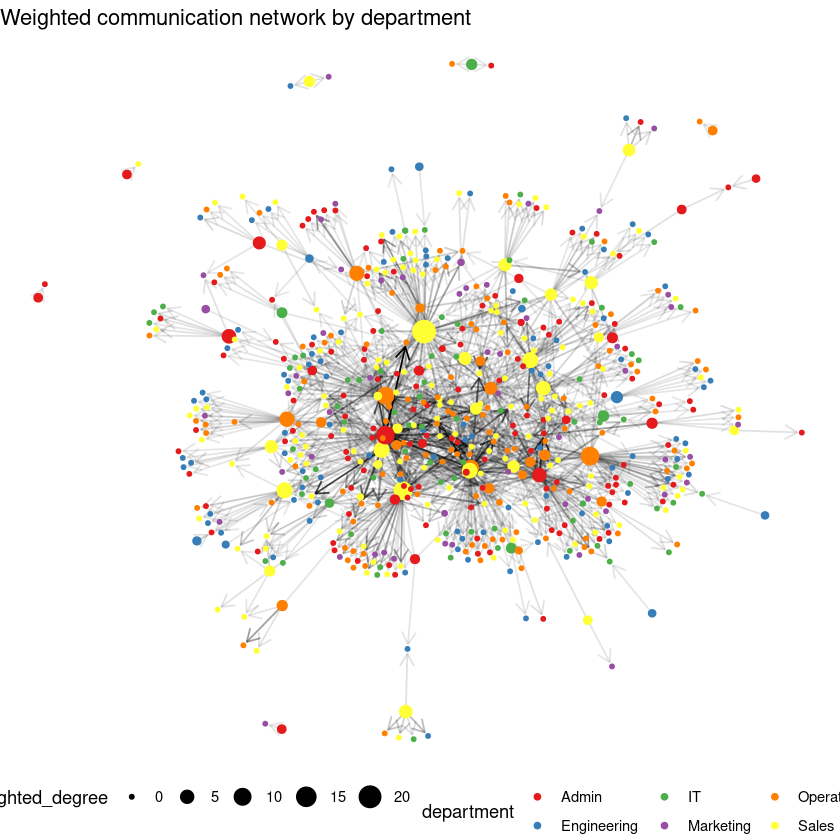

In [6]:
g_weighted %>% 
ggraph(layout = "fr")+
geom_edge_link(show.legend=FALSE,
    aes(alpha = messages),
    arrow = arrow(length = unit(3, 'mm')), 
              end_cap = circle(1, 'mm'),
             )+
geom_node_point(aes(color = department, size = weighted_degree))+
theme_void()+
theme(legend.position = "bottom")+
scale_color_brewer(palette = "Set1")+
ggtitle("Weighted communication network by department")

A quick look at the communication network revel the preferential attachment structure of the network and highlight low homophily by the department. In other words, there are few important employees in the communication network who sends or receive most of the messages, and communication does not seem to be bounded within departments.

In [116]:
assortativity_nominal(g_weighted, V(g_weighted)$department %>% as.factor, directed = T)

[1] -0.002789629

Indeed, assortativity shows almost 0 homophily in the network by department, so employees do not communicate within department more, than between departments.

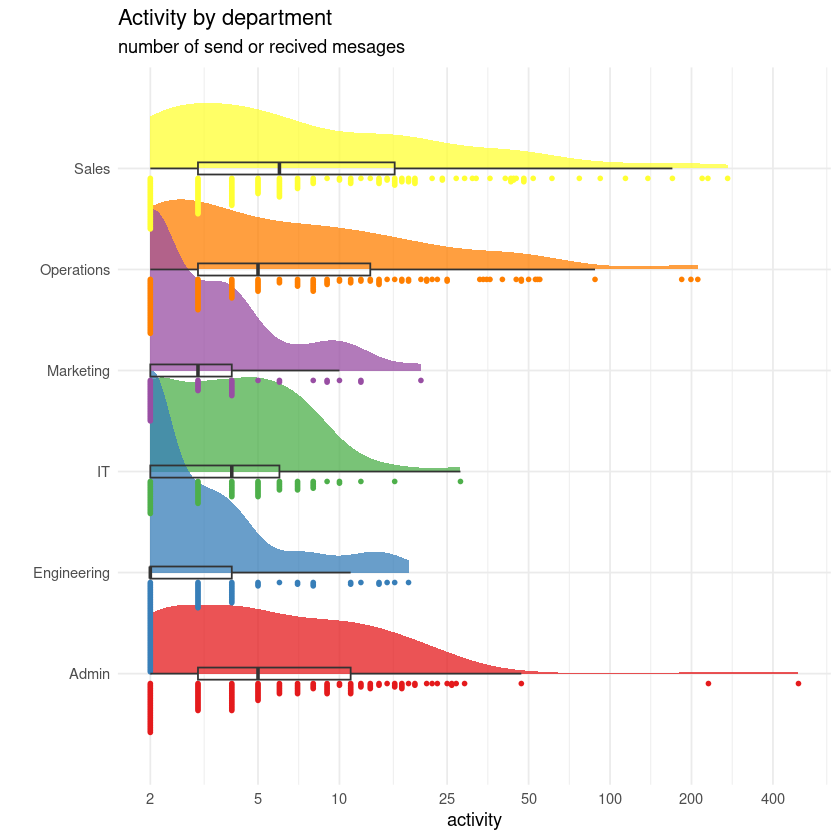

In [115]:
g_full %>% 
activate(nodes) %>% 
mutate(activity = centrality_degree(mode = "all")+1) %>% 
as_tibble() %>% 
  ggplot(aes(y = department, x = activity)) +
  stat_slab(aes(thickness = after_stat(pdf), 
                fill = department), 
             alpha = 0.75,
            scale = 2,
            adjust = 1, 
            justification = 0) +
  stat_dots(
    aes(color = department),
    side = "left", justification = 1.1, size = 2)+
  geom_boxplot(fill = NA, outlier.color = NA, width = 0.12)+
  theme_minimal()+
  theme(legend.position="none")+
  ggtitle("Activity by department", "number of send or recived mesages")+
ylab("")+
scale_color_brewer(palette = "Set1")+
scale_fill_brewer(palette = "Set1")+
scale_x_continuous(trans='log2', breaks = c(0, 0.5, 1, 2, 5, 10, 25, 50, 100, 200, 400))

Looking at the activity by department, we see that Sales, Operations and Admin send or recieve the most messages on median

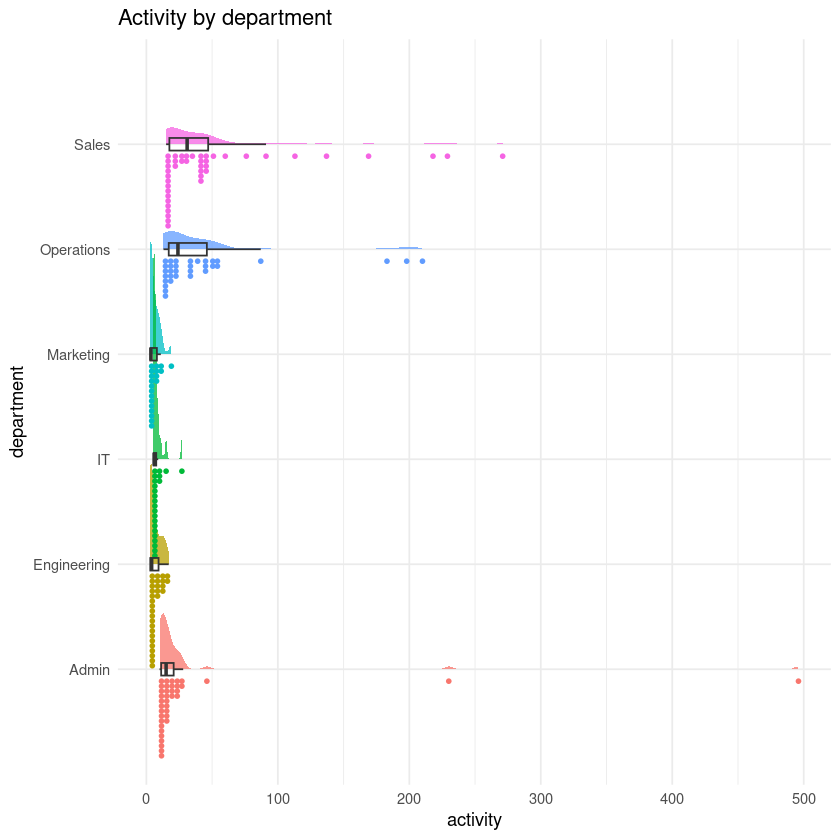

In [8]:
g_full %>% 
activate(nodes) %>% 
mutate(activity = centrality_degree(mode = "all")) %>% 
as_tibble() %>% 
group_by(department) %>% 
slice_max(order_by = activity, prop = 0.25) %>% 
ungroup() -> df_activity

df_activity %>% 
  ggplot(aes(y = department, x = activity)) +
  stat_slab(aes(thickness = after_stat(pdf), 
                fill = department), 
             alpha = 0.75,
            scale = 2,
            adjust = 1, 
            justification = 0) +
  stat_dots(
    aes(color = department),
    side = "left", justification = 1.1, size = 2)+
  geom_boxplot(fill = NA, outlier.color = NA, width = 0.12)+
  theme_minimal()+
  theme(legend.position="none")+
  ggtitle("Activity by department")

Since most employees send only a few messages, lets assume that department as active as it's 25% most active employees. Thus, Operations and Sales wrest the lead from Admin, we could not be sure how significant this differece is, so lets perfrom a quick stat test to validate initial findings.

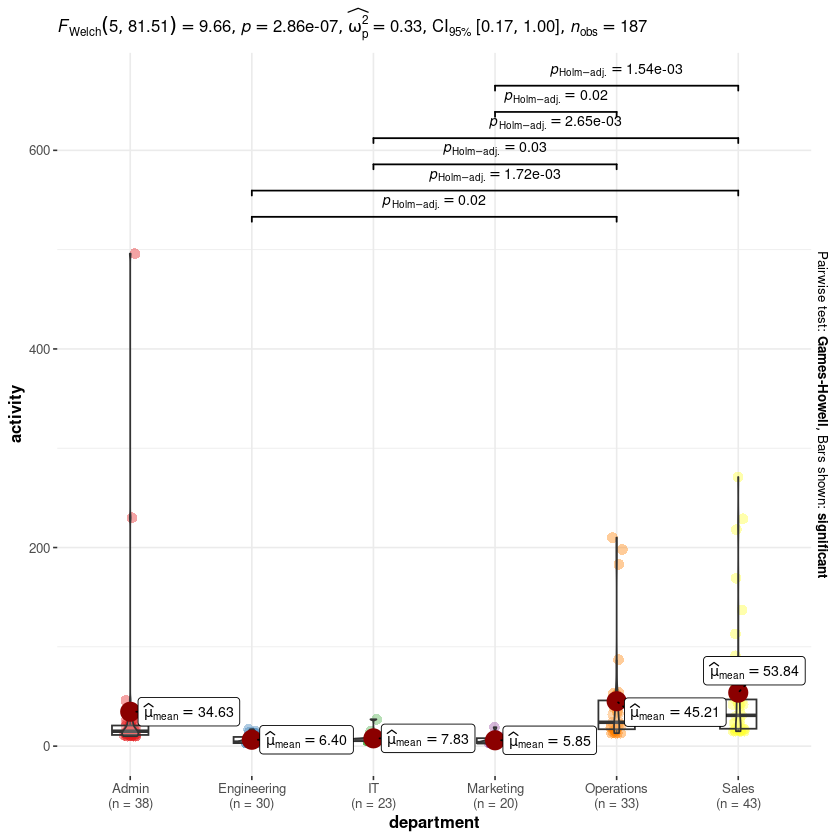

In [117]:
df_activity %>% 
ggbetweenstats(x = department, 
               y = activity,
              pairwise.comparisons = T,
              palette = "Set1")

No wonder, but top employees in Operations and Sales on average more active, than top employees from majority other departments. However, we lack evidence to say with certainty whether the Sales (45 messages) or Operations (54 messages) department is more active on average.

#### Who has the most connection?

In [10]:
g_weighted %>% 
activate(nodes) %>% 
mutate(connections = centrality_degree(mode = "all")) %>% 
as_tibble() %>% 
slice_max(order_by = connections, n = 10) %>% 
select(-id, -weighted_degree)


name,department,location,age,connections
<chr>,<chr>,<chr>,<dbl>,<dbl>
598,Operations,US,38,84
144,Sales,US,50,78
128,Sales,France,47,75
605,Admin,France,31,71
586,Operations,France,38,65
389,Sales,France,39,62
317,Operations,US,37,55
509,Admin,US,39,55
337,Sales,US,37,42


At the individual level, it is clear, that employee 598 is the most active person in the company. By the way, they are from the Operations Department, but let's not upset the Sales Department, since the second and third places were taken by employees from this Sales.

### Who is the most influential?

We will measure influence as Kleinberg's authority centrality scores, that shows importance of position in information flow. In this way somebody with high Kleinberg's authority accomulate information from many sources and could effectively use it.

In [118]:
g_full %>% 
activate(nodes) %>% 
mutate(influence = centrality_authority())  %>% 
as_tibble() -> df_influence

df_influence %>% 
arrange(-influence) %>% 
select(-id) %>% 
head(10)

name,department,location,age,influence
<chr>,<chr>,<chr>,<dbl>,<dbl>
704,Operations,US,30,1.0000000
734,Sales,France,49,0.5789497
254,Sales,France,44,0.4959219
272,Operations,US,47,0.4898694
317,Operations,US,37,0.4601673
830,Sales,Germany,51,0.4341285
103,Sales,Brasil,23,0.3932323
263,Operations,France,35,0.3909003
32,Sales,UK,54,0.3764999


The most influential employee is 704 from Operations. Can you guess where the next two most influential employees come from? That's right, Sales.

Joining, by = "name"


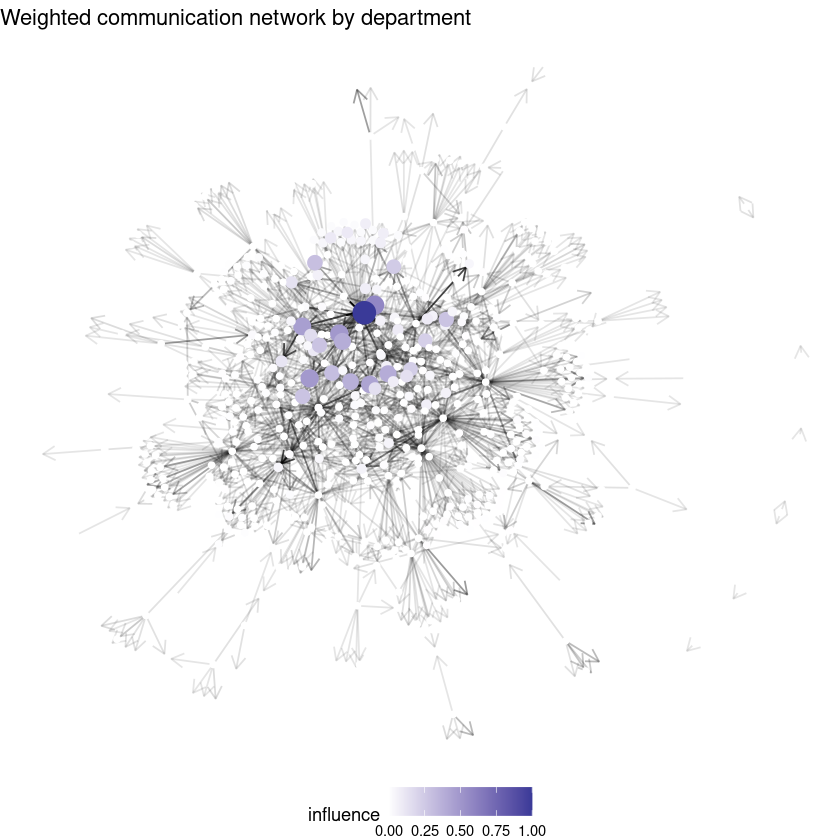

In [12]:
g_weighted %>% 
activate(nodes) %>% 
left_join(df_influence %>% select(name, influence)) %>% 
ggraph(layout = "fr")+
geom_edge_link(show.legend=FALSE,
    aes(alpha = messages),
    arrow = arrow(length = unit(3, 'mm')), 
              end_cap = circle(1, 'mm'),
             )+
geom_node_point(aes(color = influence))+
geom_node_point(aes(color = influence, size = influence), show.legend=FALSE)+
theme_void()+
theme(legend.position = "bottom")+
ggtitle("Weighted communication network by department")+
scale_colour_gradient2()

At the level of the entire organization, we can see that important employees are not only in the center of the network and have many connections, but also well connected with those who are connected to the remote parts of the network.

#### Departments Influence

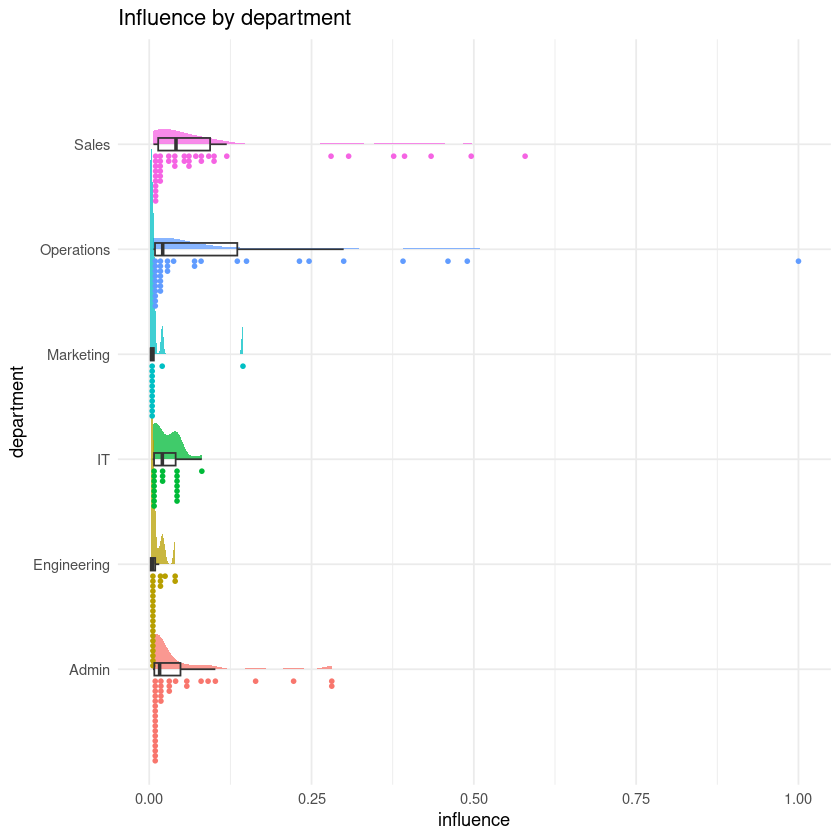

In [13]:
df_influence %>% 
group_by(department) %>% 
slice_max(order_by = influence, prop = 0.25) %>% 
ungroup() %>% 
ggplot(aes(y = department, x = influence)) +
  stat_slab(aes(thickness = after_stat(pdf), 
                fill = department), 
             alpha = 0.75,
            scale = 2,
            adjust = 1, 
            justification = 0) +
  stat_dots(
    aes(color = department),
    side = "left", justification = 1.1, size = 2)+
  geom_boxplot(fill = NA, outlier.color = NA, width = 0.12)+
  theme_minimal()+
  theme(legend.position="none")+
  ggtitle("Influence by department")

Again, we will consider the influence of the department as the top quarter of its most influential employees. In this way, Sales seems to be more influencal on average, than other departments

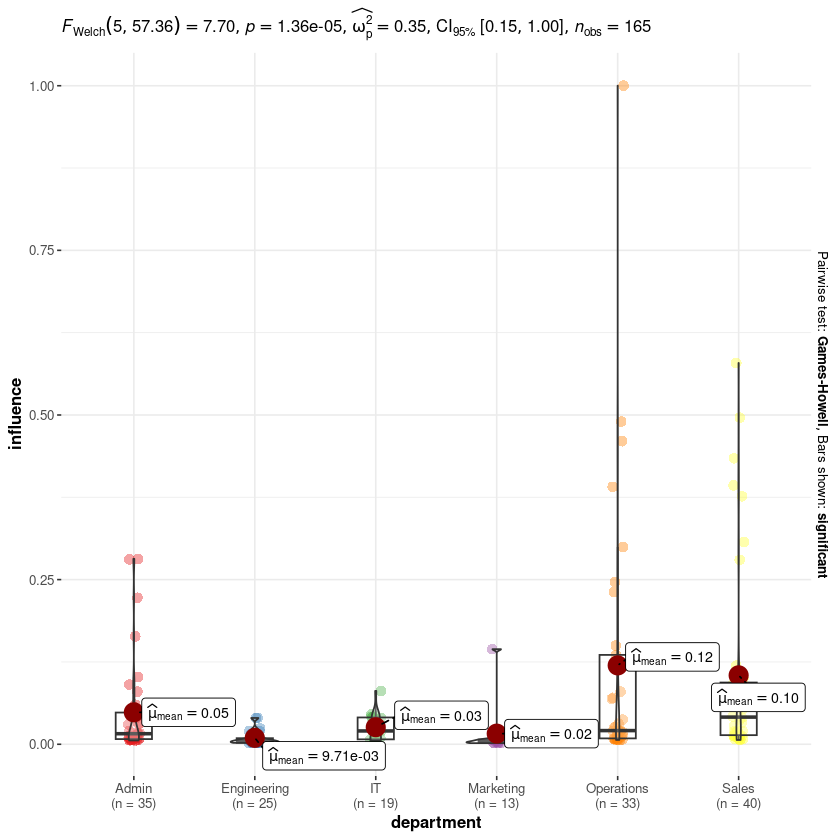

In [14]:
df_influence %>% 
group_by(department) %>% 
slice_max(order_by = influence, prop = 0.25) %>% 
ungroup() %>% 
# filter(department %in% c("Admin", "Operations", "Sales")) %>% 
ggbetweenstats(x = department, 
               y = influence,
              pairwise.comparisons = T,
              palette = "Set1")

However, the stat test does not give us any confidence in that claim, so we could not say, which department is the most influential on average. However, 6 out of 10 of the most influential employees are from Sales (while Operations have 4 out of 10), so let's say that Sales and Operations again split the first place.

## How to Boost collaboration

In order to improve collaboration we will look at two metrics:
+ Network diameter
+ Network Mean distance
From scholarship we know, that the smaller degree of separation, the easier activates social capital, and the easier is to transfer information from one person to another. Therefore, mean distance shows how far away each employee is from every other employee, and diameter indicates the largest distance in the whole network.

In [119]:
print("Mean distance:")
g_weighted %>% mean_distance()
print("diameter:")
g_weighted %>% diameter()

[1] "Mean distance:"


[1] 3.910146

[1] "diameter:"


[1] 10

On average every person in the organization is 4 people away from every other person in organization, so it will not be so easy to collaborate.

In [50]:
employees %>% 
select(id, department) %>% 
mutate(id2 = id) |> 
group_by(department) |> 
expand(id, id2) |> 
filter(id != id2) |> 
ungroup()  %>% 
rename(from = id, to = id2) %>% 
left_join(
    g_weighted %>% 
	activate(edges) %>% 
	as_tibble() %>% 
	select(-messages) %>% 
	mutate(remove = "present")
) %>% 
mutate(remove = remove  %>% as.character(), messages = 1)  %>% 
filter(is.na(remove)) %>% 
select(-remove) -> employees_full


Joining, by = c("from", "to")


department,from,to,messages
<chr>,<dbl>,<dbl>,<dbl>
Admin,9,29,1
Admin,9,36,1
Admin,9,42,1
Admin,9,50,1
Admin,9,51,1
Admin,9,68,1
Admin,9,73,1
Admin,9,74,1
Admin,9,121,1


In [29]:
messages %>% 
count(sender, receiver) %>% 
rename(messages = n, from = sender, to = receiver) %>%
bind_rows(employees_full) %>% 
graph_from_data_frame() %>% 
as_tbl_graph()  %>% 
activate(nodes) %>% 
left_join(employees %>% mutate(name = id %>% as.character)) -> graph_department_full


graph_department_full %>% mean_distance()
graph_department_full %>% diameter()

Joining, by = "name"


[1] 2.386619

[1] 5

Firstly, let's think about a complete communication network by department, i.e. every single person talks to all people in the department. That might be our best possible outcome if we organize some social events within the departments.
That gives us a nearly 58% percentage per cent decrease in the mean distance (lower is better) and cuts the network diameter in half.

That is a really welcome outcome, for the intervention, but impossible to achieve on a scale of the whole company. Therefore, let's focus on a single department.

In [122]:
departments = employees %>% pull(department) %>% unique
departments

messages %>% 
count(sender, receiver) %>% 
rename(messages = n, from = sender, to = receiver) -> messages_weighted

vector_mean_distance = 1:length(departments)
vector_diameter = 1:length(departments)

graph_collaboration <- function(df_full = employees_full,
    							df = messages_weighted,
                               department = NA,
                               prop = 1){
        df %>% 
    bind_rows(df_full) %>% 
	graph_from_data_frame() -> temp_graph

    tibble(mean_distance = temp_graph %>% mean_distance(),
          diameter = temp_graph %>% diameter(),
          department = department,
          prop = prop)
}

df_reslts = tibble(
    mean_distance = NA,
    diameter = NA,
    department = NA
)

for (i in departments) {
    df_reslts <- df_reslts %>% 
    bind_rows(
    	employees_full %>% 
		filter(department == i) %>% 
		graph_collaboration(department = i)
        )
}

df_reslts %>% 
na.omit() %>% 
arrange(mean_distance)

[1] "Operations"  "Sales"       "IT"          "Admin"       "Marketing"  
[6] "Engineering"

mean_distance,diameter,department,prop
<dbl>,<dbl>,<chr>,<dbl>
2.265923,7,Sales,1
2.469112,10,Engineering,1
2.482439,8,Operations,1
2.595541,7,Admin,1
4.423272,11,IT,1
4.866480,12,Marketing,1


Secondly, let's estimate the theoretical maximum that can be increased by pushing just one department to communicate more with a friend. From the table we can see that the mega party in the Sales Department not only affected the smallest network diameter, but also the smallest average distance. (lower is better).
Hooray! We have a clear contender for a party that will benefit the entire company.

### Simulation

In [123]:
set.seed(2022)
df_reslts = tibble(
    mean_distance = NA,
    diameter = NA,
    department = NA
)

for (i in 1:200) {
    df_reslts <- df_reslts %>% 
    bind_rows(
    	employees_full %>% 
        slice_sample(prop = 0.05) %>% 
		filter(department == "Sales") %>% 
		graph_collaboration(department = "Sales", prop = 0.05)
        )
}

df_reslts %>% na.omit() -> sales_boost_01

Joining, by = "name"
Joining, by = "name"


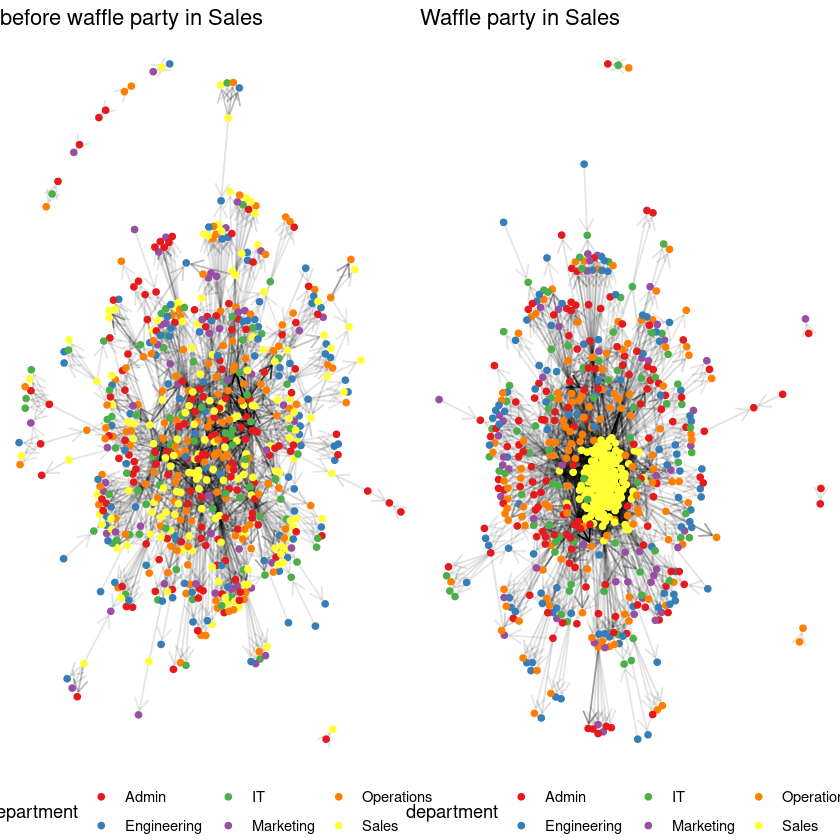

In [121]:
messages %>% 
count(sender, receiver) %>% 
rename(messages = n, from = sender, to = receiver) %>%
bind_rows(employees_full %>% filter(department == "Sales") %>% slice_sample(prop = 0.05)) %>% 
graph_from_data_frame() %>% 
as_tbl_graph()  %>% 
activate(nodes) %>% 
left_join(employees %>% mutate(name = id %>% as.character))  %>% 
ggraph(layout = "fr")+
geom_edge_link(show.legend=FALSE,
    aes(alpha = messages),
    arrow = arrow(length = unit(3, 'mm')), 
              end_cap = circle(1, 'mm'),
             )+
geom_node_point(aes(color = department))+
theme_void()+
theme(legend.position = "bottom")+
scale_color_brewer(palette = "Set1")+
ggtitle("Waffle party in Sales") -> gg_sales

messages %>% 
count(sender, receiver) %>% 
rename(messages = n, from = sender, to = receiver) %>%
# bind_rows(employees_full %>% filter(department == "Sales") %>% slice_sample(prop = 0.05)) %>% 
graph_from_data_frame() %>% 
as_tbl_graph()  %>% 
activate(nodes) %>% 
left_join(employees %>% mutate(name = id %>% as.character))  %>% 
ggraph(layout = "fr")+
geom_edge_link(show.legend=FALSE,
    aes(alpha = messages),
    arrow = arrow(length = unit(3, 'mm')), 
              end_cap = circle(1, 'mm'),
             )+
geom_node_point(aes(color = department))+
theme_void()+
theme(legend.position = "bottom")+
scale_color_brewer(palette = "Set1")+
ggtitle("before waffle party in Sales") -> gg_before

grid.arrange(gg_before, gg_sales, ncol=2)

approximate consequences if we activate 5% of the possible contacts between employees of the Sales department.

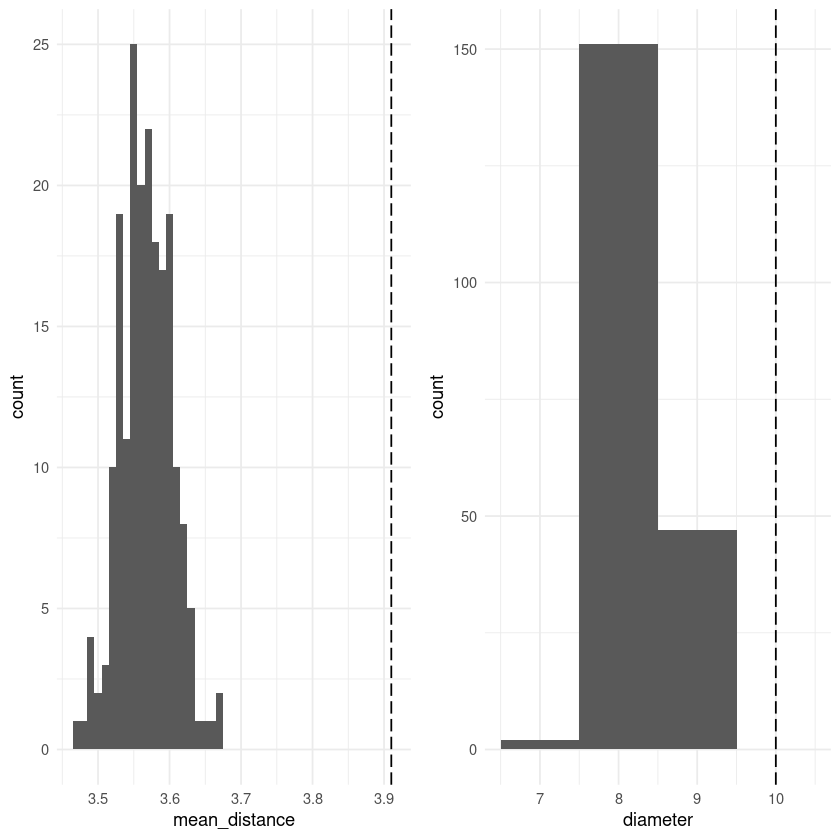

In [128]:
sales_boost_01 %>% 
ggplot(aes(x = mean_distance))+
geom_histogram(binwidth = 0.01)+
geom_vline(xintercept = g_weighted %>% mean_distance(), linetype = "longdash")+
theme_minimal() -> g_md

sales_boost_01 %>% 
ggplot(aes(x = diameter))+
geom_histogram(binwidth = 1)+
geom_vline(xintercept = g_weighted %>% diameter(), linetype = "longdash")+
theme_minimal() -> g_di

grid.arrange(g_md, g_di, ncol = 2)

A simulation of 200 possible ways to randomly introduce employees at a party shows that in all cases there will be more fertile ground for collaboration than in the original network.

The recommendation is based on the fact that although sales is by many characteristics already the most important department, since they communicate frequently and actively with other departments, sales can improve communication throughout the company.

This report recommends hosting a Waffle Party where salespeople can connect with each other. However, a better effect will be achieved if they are encouraged to communicate with colleagues they do not know. This can be achieved by generating the desired network and splitting the whole network into groups more suitable for corporate events.

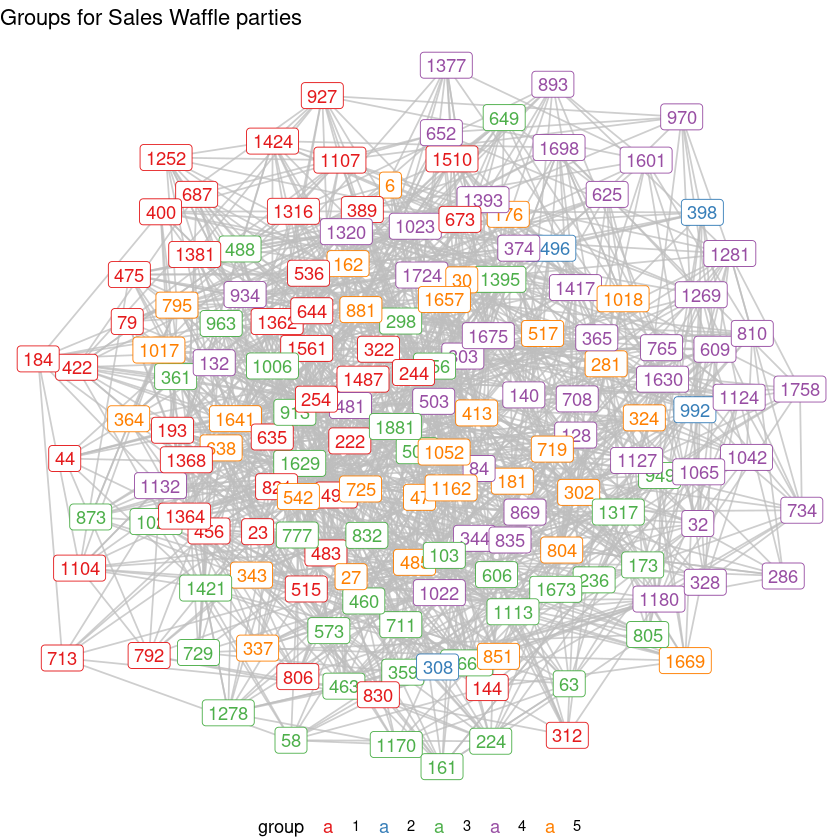

In [195]:
set.seed(2022)
employees_full %>% 
filter(department == "Sales") %>% 
slice_sample(prop = 0.05) %>% 
select(from, to) %>% 
graph_from_data_frame() -> g1

g1 %>% 
simplify(remove.multiple = TRUE)  %>% 
as.undirected() %>% 
cluster_fast_greedy() -> fg

V(g1)$group = membership(fg)

g1 %>% 
as_tbl_graph() %>% 
mutate(group = group %>% as.factor) %>% 
ggraph(layout = "fr")+
geom_edge_link(show.legend=FALSE,
               color = "grey",
               alpha = 0.75,
              end_cap = circle(1, 'mm'),
             )+
# geom_node_point(aes(color = group), size = 3)+
geom_node_label(aes(label  = name, color = group))+
theme_void()+
theme(legend.position = "bottom")+
scale_color_brewer(palette = "Set1")+
ggtitle("Groups for Sales Waffle parties") 


In [197]:
g1 %>% 
as_tbl_graph() %>% 
mutate(group = group %>% as.factor) %>% 
as_tibble() %>% 
rename(id = name) %>% 
arrange(group)

id,group
<chr>,<fct>
422,1
687,1
483,1
389,1
456,1
1424,1
144,1
496,1
515,1


## Data source

Pietro Panzarasa, Tore Opsahl, and Kathleen M. Carley. "Patterns and dynamics of users' behavior and interaction: Network analysis of an online community." Journal of the American Society for Information Science and Technology 60.5 (2009): 911-932._